## Learning rate

In [1]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch import optim, nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

### 準備

In [2]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.flatten = nn.Flatten() # [b, c, h, w] -> [b, cxhxw]
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)

    def forward(self, x):
        # z1 = self.l1(x)
        # a1 = F.relu(z1)
        # z2 = self.l2(a1)
        x = self.l2(F.relu(self.l1(self.flatten(x))))
        return x


def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    no_improve = 0 # カウント用変数
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0
        
        for train_batch, data in enumerate(train_loader):
            
            X, y = data
            optimizer.zero_grad()
            # forward
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backward
            loss.backward()
            optimizer.step()
    
        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_acc/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            if save_path is not None:
                state = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_losses[-1]
                }
                torch.save(state, save_path)
        else:
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break

    return train_losses, val_losses, val_accuracies
        

In [3]:
# データロード
dataset = datasets.load_digits()
target = dataset['target']
images = dataset['images']
images = images * (255. / 16.) # 0~16 -> 0~255
images = images.astype(np.uint8)
# 学習データと検証データ作成
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# DatasetとDataLoader作成
transform = transforms.Compose([
    transforms.ToTensor(),# 0~255 -> 0~1
    transforms.Normalize((.5, ), (.5, )) # 0~1 -> -1~1
])

batch_size = 10
train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
early_stopping = 5
## Refactoring後の学習ループ
learning_rate = 0.1
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
num_epoch = 100
# train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, F.cross_entropy, num_epoch, early_stopping=5)

### Learning rate finder

In [4]:
# optimizerの.param_groupsの中に様々なパラメータが保持されていて，learning rateもここに格納されている
for param_group in opt.param_groups:
    param_group['lr'] *= 1.1

In [5]:
# opt.param_groups

In [6]:
def lr_finder(model, train_loader, loss_func, lr_multiplier=1.2):

    lr = 1e-8
    max_lr = 10
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    losses = []
    lrs = []

    for train_batch, data in enumerate(train_loader):
        X, y = data
        
        opt.zero_grad()
        # forward
        preds = model(X)
        loss = loss_func(preds, y)
        losses.append(loss.item())
        lrs.append(lr)

        # backward
        loss.backward()
        opt.step()

        lr *= lr_multiplier

        for param_group in opt.param_groups:
            param_group['lr'] = lr
        if lr > max_lr:
            break

    return lrs, losses

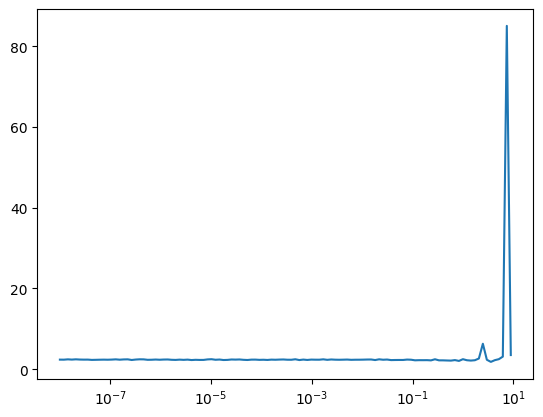

In [7]:
lrs, losses = lr_finder(model, train_loader, F.cross_entropy, lr_multiplier=1.2)
plt.plot(lrs, losses)
plt.xscale('log')

### Learning rate scheduler

In [8]:
# StepLR
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = StepLR(opt, step_size=30, gamma=0.1)
for param_group in opt.param_groups:
    print(param_group['lr'])
for epoch in range(60):
    scheduler.step()
for param_group in opt.param_groups:
    print(param_group['lr'])

0.1
0.0010000000000000002


/usr/local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


In [9]:
# CosineAnnealing
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(opt, T_max=50)
lrs = []
for epoch in range(150):
    lrs.append(opt.param_groups[0]['lr'])
    scheduler.step()

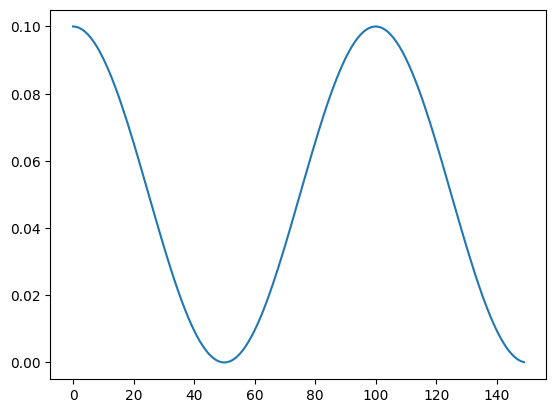

In [10]:
plt.plot(lrs)

In [11]:
# learning rate schedulerを学習ループに組み込む
def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None, scheduler=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    no_improve = 0 # カウント用変数
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0
        
        for train_batch, data in enumerate(train_loader):
            
            X, y = data
            optimizer.zero_grad()
            # forward
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backward
            loss.backward()
            optimizer.step()
    
        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_acc/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            if save_path is not None:
                state = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_losses[-1]
                }
                torch.save(state, save_path)
        else:
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break
        if scheduler:
            scheduler.step()

    return train_losses, val_losses, val_accuracies
        

In [12]:
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = StepLR(opt, step_size=30, gamma=0.1)
train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, F.cross_entropy, 100, scheduler=scheduler)

epoch: 0: train error: 1.0994325529577003, validation error: 0.3204966282678975, validation accuracy: 0.9055555462837219
epoch: 1: train error: 0.2633616233554979, validation error: 0.21851434501715833, validation accuracy: 0.9277777688370811
epoch: 2: train error: 0.1753229711127157, validation error: 0.15123103357230624, validation accuracy: 0.9499999930461248
epoch: 3: train error: 0.13556922520122802, validation error: 0.13256460154015157, validation accuracy: 0.9611111051506467
epoch: 4: train error: 0.1123790937773366, validation error: 0.1295317758211038, validation accuracy: 0.9555555482705435
epoch: 5: train error: 0.09311105858392289, validation error: 0.12744803215739214, validation accuracy: 0.9611111068063312
epoch: 6: train error: 0.08475026824615067, validation error: 0.09669917673131244, validation accuracy: 0.9749999956952201
epoch: 7: train error: 0.06930207134509045, validation error: 0.09914146240852359, validation accuracy: 0.9749999956952201
epoch: 8: train error:

In [13]:
opt.param_groups

[{'params': [Parameter containing:
   tensor([[-0.0458, -0.0303, -0.2662,  ...,  0.0403,  0.1926, -0.0481],
           [-0.0691,  0.0570,  0.0846,  ..., -0.0833,  0.0735,  0.0730],
           [ 0.0555, -0.1010, -0.0110,  ..., -0.2758, -0.0005,  0.0226],
           ...,
           [-0.0632,  0.1313,  0.1796,  ...,  0.1510, -0.2966, -0.2258],
           [-0.1218, -0.0653, -0.4149,  ...,  0.0679, -0.0590, -0.1234],
           [-0.0750, -0.0909, -0.1690,  ..., -0.1063, -0.1012, -0.1514]],
          requires_grad=True),
   Parameter containing:
   tensor([ 0.1097, -0.1063,  0.0182,  0.0161,  0.0221, -0.0955,  0.2412,  0.1377,
            0.1140,  0.0984,  0.0435,  0.0114,  0.0753, -0.0759, -0.0886,  0.0132,
            0.0264,  0.0739, -0.0696, -0.0119,  0.1522,  0.0246,  0.0079, -0.0120,
           -0.0186,  0.0879,  0.1228, -0.0080, -0.0068,  0.1824],
          requires_grad=True),
   Parameter containing:
   tensor([[-0.3075,  0.0274, -0.2107,  0.9422, -0.0525, -0.1860,  0.0269, -0.1631,

In [14]:
# 元のlearning rateとは異なる値になっていることがわかる
learning_rate

0.1